In [1]:
#to do:
#TEST do a level clear indicator with deaths, if below a certain value then it is a 1
#MEH add key for the rolling plots
#MEH, broke it up by dataframe mod have the rolling plots go full length for the longer episodes

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [50]:
#/home/jim/projects/td3/logs/log_1541869275_1.monitor.csv

def get_results(time_id,base_dir='logs',df_mod=1):
    df_list = []
    env_name_list = []
    for i in range(100):
        file_str = '{}/log_{}_{}.monitor.csv'.format(base_dir,time_id,i)
        file_exists_check = Path(file_str)
        if file_exists_check.is_file():
            print(file_str)
            df = get_df(file_str,i)
            df_list.append(df)
            env_name = "env {}".format(i)
            env_name_list.append(env_name)
        else:
            break
    
    #get_scatter_plots(df_list)
    #get_rolling_plots(df_list)
    if len(df_list) > 0:
        describe_df_array(df_list,df_mod)
        get_rolling_comparison(df_list,env_name_list)
        if df_mod > 1:
            #rolling comparisons by df_slice too
            start_index = -1
            for i in range(0,df_mod):
                start_index += 1
                env_name_sublist = [start_index]
                base_df_list = [df_list[start_index]]
                for j in range(df_mod,len(df_list)):
                    if j % df_mod == start_index:
                        #base_df = pd.concat([base_df,df_list[j]])
                        base_df_list.append(df_list[j])
                        env_name_sublist.append(j)
                print("Doing rolling comparison for df mod {}".format(start_index))
                get_rolling_comparison(base_df_list,env_name_sublist)   
                
    else:
        print("no files found, perhaps incorrect id?")


#contra:
#first two decimal points are number of deaths with 0.01 subtracted for each death
#if you clear the level 0.5 added to deaths, have to move this out (can't lose more than 50 lives so this won't overlap)
#next 4 decimal points are number of scrolls

def get_df(file_str,i):
    mf = pd.read_csv(file_str)
    mf['t_diff'] = mf.t.diff()
    mf['deaths'] = 100 - np.floor(mf.r*100 % 100)
    mf['success'] = (mf.deaths >= 50)*1.
    mf['scrolls'] = mf.r*1000000 % 10000
    mf['deaths'][mf.deaths >= 50] = mf.deaths - 50
    mf['sc_per_d'] = mf['scrolls'] / (mf['deaths']+1)
    mf['env'] = i       
    
    return mf

def describe_df_array(df_array,df_mod=1):
    
    for i in df_array:
        print("Mean Reward last 100 Episodes per env: {}".format(np.mean(i.r.iloc[-100:])))
        
    def describe_df(mf,description=""):
        print(description)
        print(mf.describe())
        print("Max reward values:")
        print(mf.r.sort_values(ascending=False)[0:10])
        print("Max l values:")
        print(mf.l.sort_values(ascending=False)[0:10])
        print("Max score to deaths values")
        print(mf.sc_per_d.sort_values(ascending=False)[0:10])
        print("Total success {} % success {} ".format(np.sum(mf.success), np.sum(mf.success)/len(mf.success)))
    
    if df_mod <= 1:
        mf = pd.concat(df_array)
        describe_df(mf,"Combined DataFrame Description")
    else:
        start_index = -1
        for i in range(0,df_mod):
            start_index += 1
            base_df = df_array[start_index]
            for j in range(df_mod,len(df_array)):
                if j % df_mod == start_index:
                    base_df = pd.concat([base_df,df_array[j]])
                    
            describe_df(base_df,"Mod DataFrame Descriptions {}".format(start_index))
                    
                    

def get_scatter_plots(df):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.scatter(df.index,df.r,marker='.')
    plt.ylabel('reward')
    plt.xlabel('episode')
    plt.show()
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.scatter(df.index,df.l,marker='.')
    plt.ylabel('timesteps per episode')
    plt.xlabel('episode')
    plt.show()
    
#     a4_dims = (11.7, 8.27)
#     fig, ax = plt.subplots(figsize=a4_dims)
#     plt.scatter(df.index,df.t_diff,marker='.')
#     plt.ylabel('time per episode')
#     plt.xlabel('episode')
#     plt.show()
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.scatter(df.index,df.success,marker='.')
    plt.ylabel('success')
    plt.xlabel('episode')
    plt.show()
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    plt.scatter(df.index,df.sc_per_d,marker='.')
    plt.ylabel('scrolls per death')
    plt.xlabel('episode')
    plt.show()
    

def get_rolling_plots(df):
    rolling_window_size = 100
    if len(df.r) < 1000:
        rolling_window_size = 50
        
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.tsplot(df.r.rolling(rolling_window_size).mean())
    plt.ylabel('reward')
    plt.xlabel('mean of last {} episodes'.format(rolling_window_size))
    plt.show()
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.tsplot(df.l.rolling(rolling_window_size).mean())
    plt.ylabel('timesteps')
    plt.xlabel('mean of last {} episodes'.format(rolling_window_size))
    plt.show()
    
#     a4_dims = (11.7, 8.27)
#     fig, ax = plt.subplots(figsize=a4_dims)
#     sns.tsplot(df.t_diff.rolling(rolling_window_size).mean())
#     plt.ylabel('time')
#     plt.xlabel('mean of last {} episodes'.format(rolling_window_size))
#     plt.show()
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.tsplot(df.success.rolling(rolling_window_size).mean())
    plt.ylabel('success')
    plt.xlabel('mean of last {} episodes'.format(rolling_window_size))
    plt.show()
    
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.tsplot(df.sc_per_d.rolling(rolling_window_size).mean())
    plt.ylabel('scrolls per death')
    plt.xlabel('mean of last {} episodes'.format(rolling_window_size))
    plt.show()
    

        
# def get_level_comparison(lvl_array):
#     df_array = []
#     for i in range(len(lvl_array)):
#         file_str = '{}/monitor.csv'.format(lvl_array[i])
#         df_array.append(pd.read_csv(file_str))
#         df_array[i]['t_diff'] = df_array[i].t.diff()
#         df_array[i]['success'] = (df_array[i].r > 9000)*1.
#         print(lvl_array[i])
#         print(df_array[i].describe())
        
#     get_rolling_comparison(df_array,lvl_array)

    
def plot_rolling_mean(df,col_name,rolling_window_size=100):
    a4_dims = (11.7, 8.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.tsplot(df[col_name].rolling(rolling_window_size).mean())
    plt.ylabel(col_name)
    plt.xlabel('mean of last {} episodes'.format(rolling_window_size))
    plt.legend(loc='upper left');
    plt.show()
    
def plot_rolling_mean_array(df_list,col_name,rolling_window_size=100):
    color_dict = {0:'red', 1:'blue', 2:'green', 3:'black', 4:'grey', 5:'yellow', 6:'purple', 7:'orange'}
    color_range = len(color_dict)

    a4_dims = (14.7, 8.27)
    fig, ax1 = plt.subplots(figsize=a4_dims)
    print("Rolling Plot {}".format(col_name))
    i_range = 0;
    for i in df_list:
        sns.tsplot(i[col_name].rolling(rolling_window_size).mean(),color=color_dict[i_range%color_range])
        i_range += 1
    plt.ylabel(col_name)
    plt.xlabel('episode') 
    plt.legend(loc='upper left');
    plt.show()
    
    
def get_rolling_comparison(df_array, lvl_array):
    rolling_window_size = 100
    if len(df_array[0]) < 1000:
        rolling_window_size = 50
        
    plot_rolling_mean_array(df_array,'r',rolling_window_size)
    plot_rolling_mean_array(df_array,'l',rolling_window_size)
    plot_rolling_mean_array(df_array,'success',rolling_window_size)
    plot_rolling_mean_array(df_array,'sc_per_d',rolling_window_size)
        
    a4_dims = (14.7, 8.27)
    fig, ax1 = plt.subplots(figsize=a4_dims)
    print("Reward Scatter Plot")
    i_range = 0;
    for i in df_array:
        ax1.scatter(i.index,i.r,marker='.',label=i_range)
        i_range += 1
    plt.ylabel('reward')
    plt.xlabel('episode') 
    plt.legend(loc='upper left');
    plt.show()
    
    a4_dims = (14.7, 8.27)
    fig, ax1 = plt.subplots(figsize=a4_dims)
    print("Timesteps Scatter Plot")
    i_range = 0;
    for i in df_array:
        ax1.scatter(i.index,i.l,marker='.',label=i_range)
        i_range += 1
    plt.ylabel('Timesteps')
    plt.xlabel('episode') 
    plt.legend(loc='upper left');
    plt.show()
    
    a4_dims = (14.7, 8.27)
    fig, ax1 = plt.subplots(figsize=a4_dims)
    print("Success Scatter Plot")
    i_range = 0;
    for i in df_array:
        ax1.scatter(i.index,i.success,marker='.',label=i_range)
        i_range += 1
    plt.ylabel('Success')
    plt.xlabel('episode') 
    plt.legend(loc='upper left');
    plt.show()
    
#     temp_index = 0
#     for i in df_array:
#         print(lvl_array[temp_index], " reward")
#         temp_index += 1
#         plot_rolling_mean(i,'r',rolling_window_size)
        
#     temp_index = 0
#     for i in df_array:
#         print(lvl_array[temp_index], " success")
#         temp_index += 1
#         plot_rolling_mean(i,'success',rolling_window_size)
        
# #     temp_index = 0
# #     for i in df_array:
# #         print(lvl_array[temp_index], " timesteps")
# #         temp_index += 1
# #         plot_rolling_mean(i,'l',rolling_window_size)

#     temp_index = 0
#     for i in df_array:
#         print(lvl_array[temp_index], "Scrolls Per Death")
#         temp_index += 1
#         plot_rolling_mean(i,'sc_per_d',rolling_window_size)

#     temp_index = 0
#     for i in df_array:
#         a4_dims = (11.7, 8.27)
#         fig, ax = plt.subplots(figsize=a4_dims)
#         print(lvl_array[temp_index], " reward")
#         plt.scatter(i.index,i.r,marker='.')
#         plt.ylabel('reward')
#         plt.xlabel('episode')
#         plt.show()    
#         temp_index += 1
        
#     temp_index = 0
#     for i in df_array:
#         a4_dims = (11.7, 8.27)
#         fig, ax = plt.subplots(figsize=a4_dims)
#         print(lvl_array[temp_index], " success")
#         plt.scatter(i.index,i.success,marker='.')
#         plt.ylabel('success')
#         plt.xlabel('episode')
#         plt.show()    
#         temp_index += 1


logs/log_1546917770_0.monitor.csv
logs/log_1546917770_1.monitor.csv
logs/log_1546917770_2.monitor.csv
logs/log_1546917770_3.monitor.csv


/home/jim/anaconda3/envs/tf3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


logs/log_1546917770_4.monitor.csv
logs/log_1546917770_5.monitor.csv
logs/log_1546917770_6.monitor.csv
logs/log_1546917770_7.monitor.csv
logs/log_1546917770_8.monitor.csv
logs/log_1546917770_9.monitor.csv
logs/log_1546917770_10.monitor.csv
logs/log_1546917770_11.monitor.csv
logs/log_1546917770_12.monitor.csv
logs/log_1546917770_13.monitor.csv
logs/log_1546917770_14.monitor.csv
logs/log_1546917770_15.monitor.csv
logs/log_1546917770_16.monitor.csv
logs/log_1546917770_17.monitor.csv
logs/log_1546917770_18.monitor.csv
logs/log_1546917770_19.monitor.csv
logs/log_1546917770_20.monitor.csv
Mean Reward last 100 Episodes per env: 625.5808546999998
Mean Reward last 100 Episodes per env: 529.9857237199999
Mean Reward last 100 Episodes per env: 600.5157472399999
Mean Reward last 100 Episodes per env: 654.4908606699998
Mean Reward last 100 Episodes per env: 727.1759915900001
Mean Reward last 100 Episodes per env: 518.2357236299999
Mean Reward last 100 Episodes per env: 648.7808766699999
Mean Reward 

/home/jim/anaconda3/envs/tf3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.


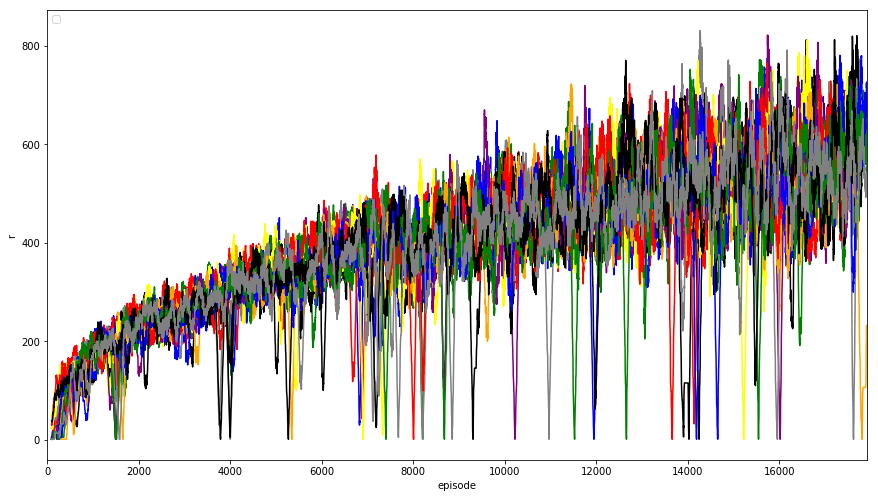

Rolling Plot l


No handles with labels found to put in legend.


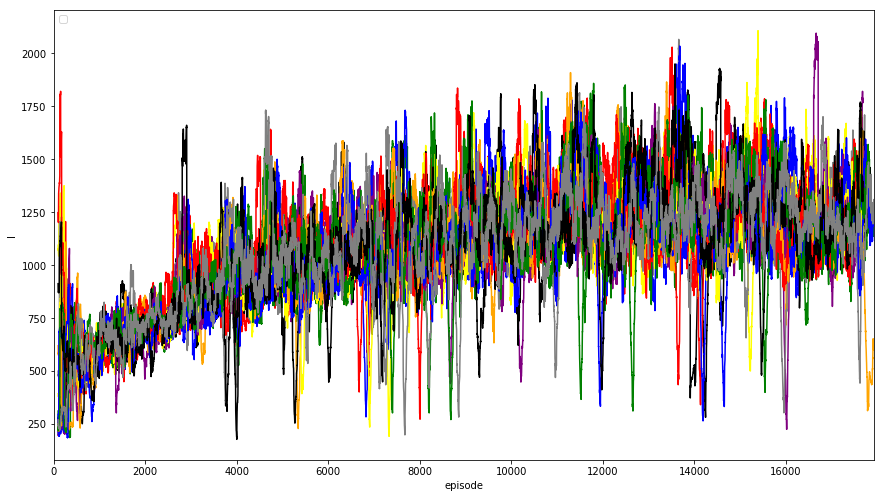

Rolling Plot success


No handles with labels found to put in legend.


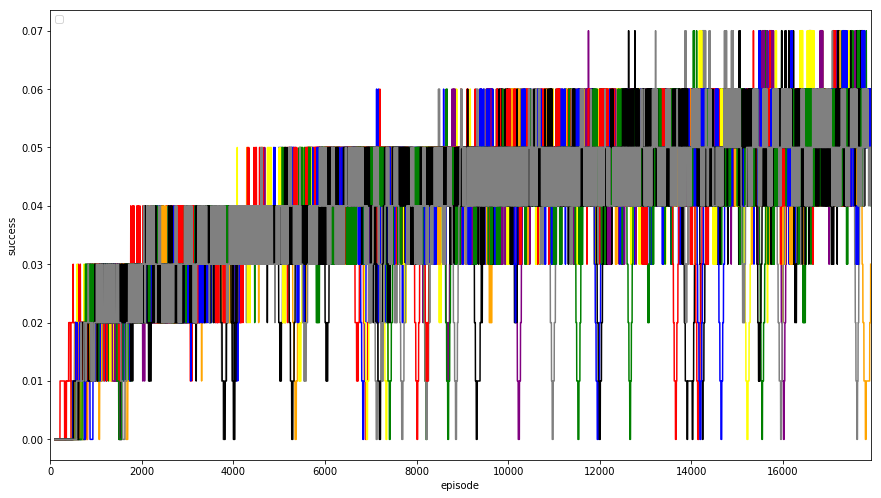

Rolling Plot sc_per_d


No handles with labels found to put in legend.


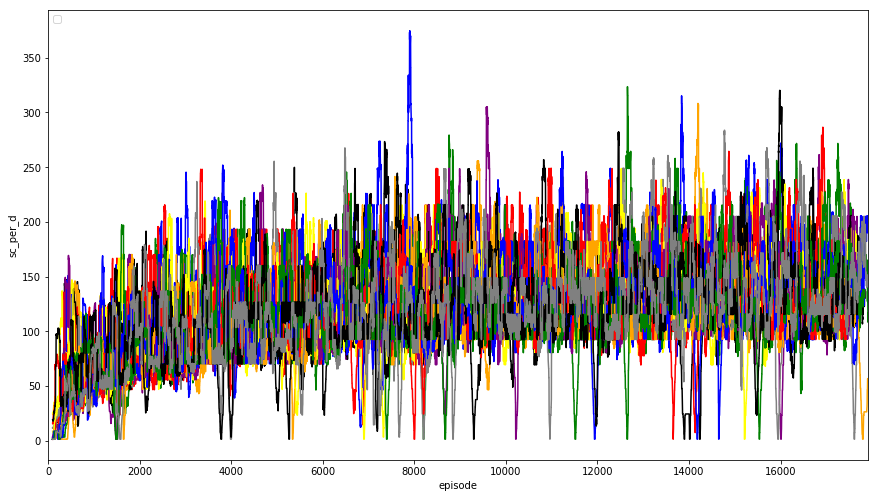

Reward Scatter Plot


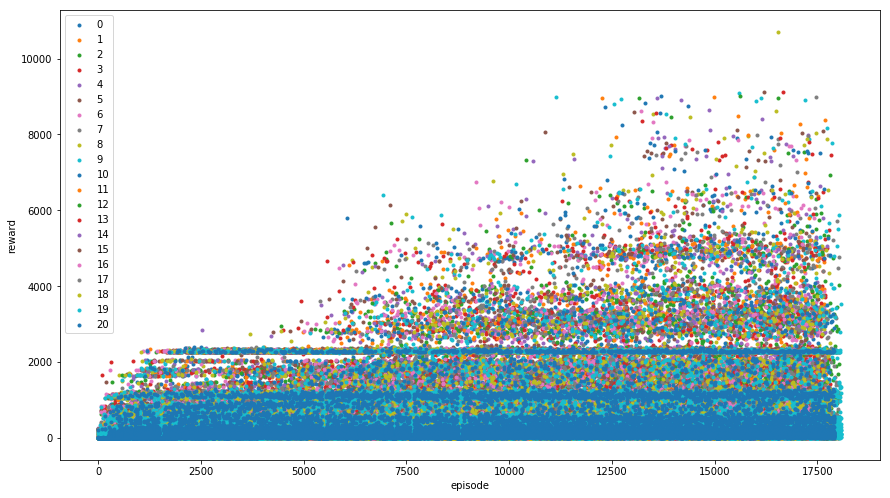

Timesteps Scatter Plot


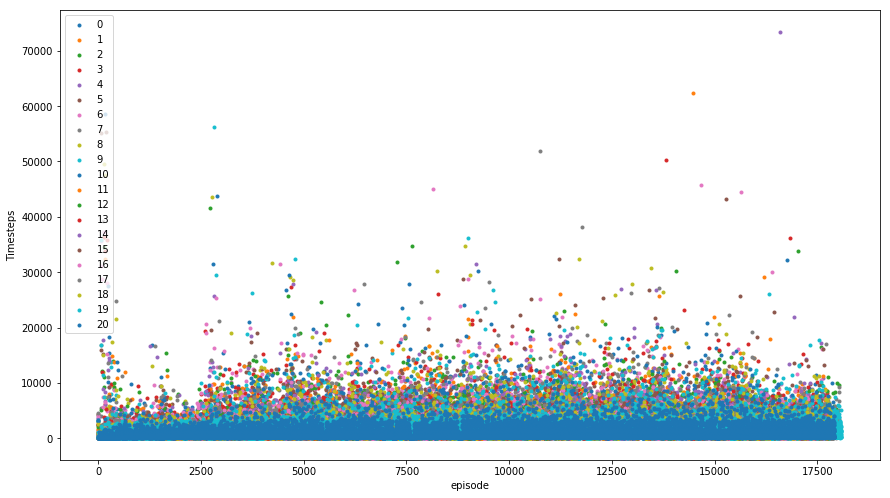

Success Scatter Plot


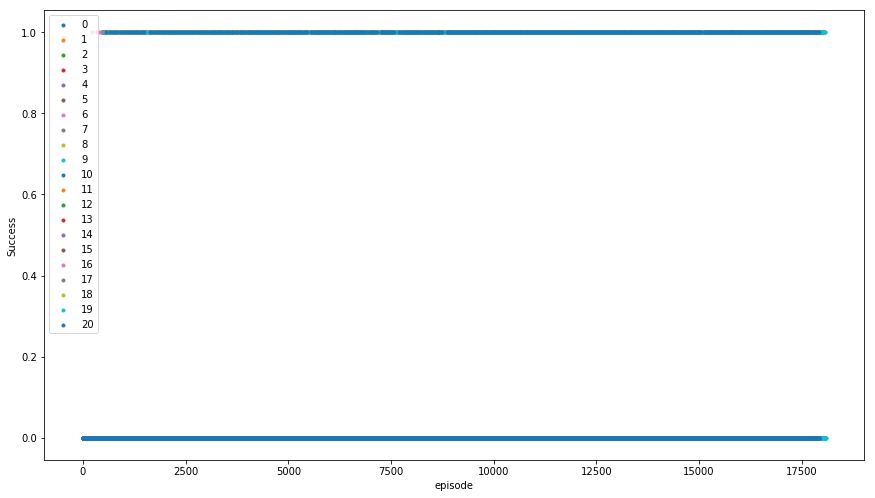

In [51]:
#tensorboard --logdir=/home/jim/projects/contra/log/1546917770
#lvl 3 run 13
get_results(time_id=1546917770,base_dir='logs',df_mod=1)

In [45]:
#deaths per lvl
#final reward ends in 0.5

def get_df_list(time_id,base_dir='logs'):
    df_list = []
    env_name_list = []
    for i in range(100):
        file_str = '{}/log_{}_{}.monitor.csv'.format(base_dir,time_id,i)
        file_exists_check = Path(file_str)
        if file_exists_check.is_file():
            print(file_str)
            df = get_df(file_str,i)
            df_list.append(df)
            env_name = "env {}".format(i)
            env_name_list.append(env_name)
        else:
            break
            
    return df_list

def get_deaths_per_level(df_list):
    death_count_list = []
    for df in df_list:
        temp_list = []
        death_count = 0
        for i in range(0,len(df.r)):
            #on episode clear reward decimal should be .5
            z1 = int(df.r[i] * 10) % 10
            if z1 == 5:
                temp_list.append(death_count)
                death_count = 0
            else:
                death_count += 1
                
        death_count_list.append(temp_list)
        
    return death_count_list
            
            
    

In [52]:
df_deaths = get_df_list(1546917770)


logs/log_1546917770_0.monitor.csv
logs/log_1546917770_1.monitor.csv
logs/log_1546917770_2.monitor.csv


/home/jim/anaconda3/envs/tf3/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


logs/log_1546917770_3.monitor.csv
logs/log_1546917770_4.monitor.csv
logs/log_1546917770_5.monitor.csv
logs/log_1546917770_6.monitor.csv
logs/log_1546917770_7.monitor.csv
logs/log_1546917770_8.monitor.csv
logs/log_1546917770_9.monitor.csv
logs/log_1546917770_10.monitor.csv
logs/log_1546917770_11.monitor.csv
logs/log_1546917770_12.monitor.csv
logs/log_1546917770_13.monitor.csv
logs/log_1546917770_14.monitor.csv
logs/log_1546917770_15.monitor.csv
logs/log_1546917770_16.monitor.csv
logs/log_1546917770_17.monitor.csv
logs/log_1546917770_18.monitor.csv
logs/log_1546917770_19.monitor.csv
logs/log_1546917770_20.monitor.csv


In [53]:
death_count_list = get_deaths_per_level(df_deaths)

In [54]:
df_death_summary = pd.DataFrame(death_count_list)
df_death_summary = df_death_summary.transpose()
pd.set_option('display.max_columns', 500)
#df_death_summary.describe()
np.round(df_death_summary.describe(), decimals=1)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,736.0,734.0,744.0,730.0,735.0,731.0,741.0,739.0,735.0,746.0,730.0,735.0,732.0,730.0,738.0,739.0,727.0,738.0,722.0,720.0,731.0
mean,23.5,23.9,24.1,24.3,24.0,23.5,23.6,24.2,23.7,24.0,23.8,24.0,24.1,24.0,23.9,23.8,23.9,23.9,24.6,24.4,24.3
std,19.2,20.3,27.4,19.9,25.3,20.9,19.4,23.7,15.8,23.5,21.8,22.0,22.7,19.8,23.7,24.4,12.6,20.3,27.5,21.6,23.2
min,8.0,7.0,8.0,9.0,8.0,8.0,9.0,9.0,6.0,8.0,9.0,8.0,8.0,8.0,9.0,9.0,9.0,6.0,7.0,6.0,10.0
25%,18.0,18.2,19.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0,18.0
50%,21.0,21.0,22.0,22.0,21.0,21.0,21.0,22.0,22.0,21.0,21.0,21.0,22.0,21.0,22.0,22.0,22.0,21.0,22.0,21.0,21.0
75%,25.0,26.0,26.0,25.0,25.0,25.0,25.0,25.0,25.5,25.8,25.0,26.0,26.0,25.8,26.0,25.0,26.0,26.0,26.0,25.2,26.0
max,471.0,513.0,738.0,465.0,642.0,539.0,483.0,590.0,351.0,606.0,547.0,494.0,564.0,483.0,615.0,639.0,211.0,488.0,693.0,504.0,574.0


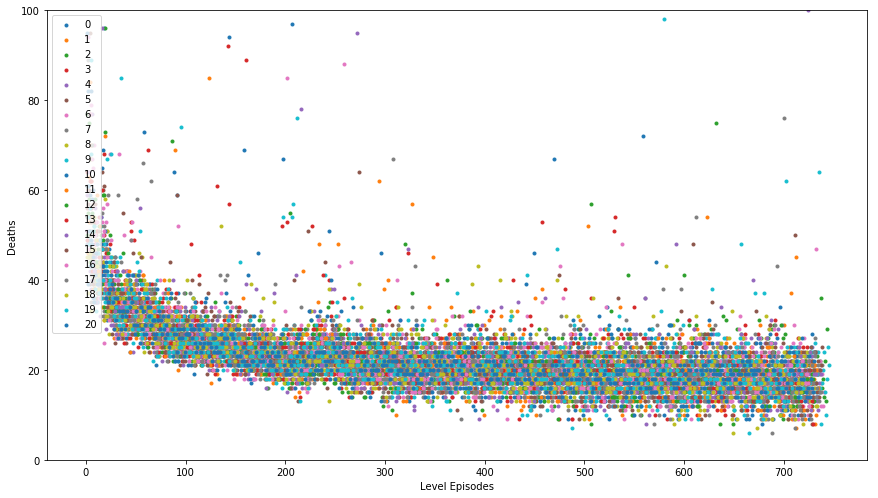

In [55]:
a4_dims = (14.7, 8.27)
fig, ax1 = plt.subplots(figsize=a4_dims)
#plt.scatter(df_death_summary[19].index,df_death_summary[19],marker='.')
i_range = 0
for i in range(len(df_death_summary.columns)):
    ax1.scatter(df_death_summary[i].index,df_death_summary[i],marker='.',label=i_range)
    i_range += 1
plt.ylabel('Deaths')
plt.xlabel('Level Episodes')
plt.ylim(0, 100)
plt.legend(loc='upper left');
plt.show()
